In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import mat73
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from scipy.signal import find_peaks
from sklearn.metrics import r2_score
import psutil
import os
import time

In [2]:
wandb.login()
# run = wandb.init(project="master-multicomponent-mri", name="3d-cnn-baseline-fullpatch")
run = wandb.init(project="master-multicomponent-mri", name="3d-cnn-baseline-fullpatch-improved")

wandb: Currently logged in as: tr-phan (trphan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
data = mat73.loadmat('../../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
input_clean_np = data['input']
ref_np = data['ref']

print("Shape of input data:", input_noisy_np.shape)
print("Shape of reference data:", ref_np.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [4]:
nan_count_input_noisy_before = np.isnan(input_noisy_np).sum()
nan_count_ref_before = np.isnan(ref_np).sum()
print(f"NaN count in input_noisy before handling: {nan_count_input_noisy_before}")
print(f"NaN count in ref before handling: {nan_count_ref_before}")

NaN count in input_noisy before handling: 1635840
NaN count in ref before handling: 0


In [5]:
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
nan_count_input_noisy_after = np.isnan(input_noisy_np).sum()
print(f"NaN count in input_noisy after handling: {nan_count_input_noisy_after}")

NaN count in input_noisy after handling: 0


In [6]:
class T1PatchDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

In [ ]:
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        # Adding channel dimension
        self.conv1 = nn.Conv3d(1, 64, kernel_size=(3,3,3), padding=(1,1,1))
        self.bn1 = nn.BatchNorm3d(64)
        self.relu1 = nn.LeakyReLU(0.1)
        
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3,3,3), padding=(1,1,1))
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.LeakyReLU(0.1)
        
        self.conv3 = nn.Conv3d(128, 256, kernel_size=(3,3,3), padding=(1,1,1))
        self.bn3 = nn.BatchNorm3d(256)
        self.relu3 = nn.LeakyReLU(0.1)
        
        self.final_conv = nn.Conv3d(256, 32, kernel_size=(8,1,1))  # Collapse temporal dimension to 32 points
        
    def forward(self, x):
        # Add channel dimension
        x = x.unsqueeze(1)
        
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        
        x = self.final_conv(x)
        
        # Remove extra dimension
        x = x.squeeze(2)
        
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, path='saved_models/best_3dcnn_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
# Transpose the input and reference data to be (N, C, H, W) format
input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

In [ ]:
# Create Dataset
dataset = T1PatchDataset(input_noisy_torch, ref_torch)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN3D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
early_stopping = EarlyStopping(patience=15, path='best_3dcnn_model.pt')

num_epochs = 200

d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Log configuration
wandb.config.update({
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "architecture": "3DCNN",
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": 15
})

In [13]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    
    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
    
    with torch.no_grad():
        for inputs, targets in progress_bar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            progress_bar_val.set_postfix({'loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    early_stopping(avg_val_loss, model)

    # Logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": current_lr
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, LR: {current_lr}')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Training finished")

Epoch [1/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.67it/s, loss=0.00426]


Epoch [1/200], Train Loss: 0.008807230498253679, Val Loss: 0.004355798913165927, LR: 0.001


Epoch [2/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.14it/s, loss=0.00411]


Epoch [2/200], Train Loss: 0.003372911119367927, Val Loss: 0.004173658423436185, LR: 0.001


Epoch [3/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.45it/s, loss=0.00313]


Epoch [3/200], Train Loss: 0.0030757028912194073, Val Loss: 0.003174057911771039, LR: 0.001


Epoch [4/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.04it/s, loss=0.012] 


EarlyStopping counter: 1 out of 15
Epoch [4/200], Train Loss: 0.002788158154192691, Val Loss: 0.012123941909521818, LR: 0.001


Epoch [5/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.82it/s, loss=0.00294]


Epoch [5/200], Train Loss: 0.0029746379346276323, Val Loss: 0.002967385354762276, LR: 0.001


Epoch [6/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.45it/s, loss=0.00253]


Epoch [6/200], Train Loss: 0.002505448414400841, Val Loss: 0.0024955260947657127, LR: 0.001


Epoch [7/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.08it/s, loss=0.00248]


EarlyStopping counter: 1 out of 15
Epoch [7/200], Train Loss: 0.0024100474464163807, Val Loss: 0.0025712126043314736, LR: 0.001


Epoch [8/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.04it/s, loss=0.00237]


Epoch [8/200], Train Loss: 0.0023594740386276196, Val Loss: 0.002330676079727709, LR: 0.001


Epoch [9/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.44it/s, loss=0.00226]


Epoch [9/200], Train Loss: 0.0022983547950085875, Val Loss: 0.002226216762016217, LR: 0.001


Epoch [10/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 60.27it/s, loss=0.00256]


EarlyStopping counter: 1 out of 15
Epoch [10/200], Train Loss: 0.002263949885382317, Val Loss: 0.002502394770272076, LR: 0.001


Epoch [11/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.97it/s, loss=0.00218]


Epoch [11/200], Train Loss: 0.0022279471380170436, Val Loss: 0.0021637453860603273, LR: 0.001


Epoch [12/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.93it/s, loss=0.00223]


EarlyStopping counter: 1 out of 15
Epoch [12/200], Train Loss: 0.002196830016716073, Val Loss: 0.00226074832258746, LR: 0.001


Epoch [13/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.99it/s, loss=0.00279]


EarlyStopping counter: 2 out of 15
Epoch [13/200], Train Loss: 0.0021796373076116045, Val Loss: 0.002788807296504577, LR: 0.001


Epoch [14/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 68.20it/s, loss=0.00238]


EarlyStopping counter: 3 out of 15
Epoch [14/200], Train Loss: 0.0021800451684976, Val Loss: 0.0022896246480134624, LR: 0.001


Epoch [15/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.73it/s, loss=0.00232]


EarlyStopping counter: 4 out of 15
Epoch [15/200], Train Loss: 0.002144781872048043, Val Loss: 0.0022962317212174336, LR: 0.001


Epoch [16/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.64it/s, loss=0.00216]


Epoch [16/200], Train Loss: 0.0021148966908610114, Val Loss: 0.0021172100313318273, LR: 0.001


Epoch [17/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.46it/s, loss=0.00206]


Epoch [17/200], Train Loss: 0.0021037320872225487, Val Loss: 0.0020285510853864253, LR: 0.001


Epoch [18/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.34it/s, loss=0.00213]


EarlyStopping counter: 1 out of 15
Epoch [18/200], Train Loss: 0.0020852438292543714, Val Loss: 0.0020931508547315995, LR: 0.001


Epoch [19/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.97it/s, loss=0.00216]


EarlyStopping counter: 2 out of 15
Epoch [19/200], Train Loss: 0.002079774219891988, Val Loss: 0.00205133543893074, LR: 0.001


Epoch [20/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.77it/s, loss=0.0021] 


Epoch [20/200], Train Loss: 0.0020628754662660263, Val Loss: 0.0020112907498454056, LR: 0.001


Epoch [21/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.55it/s, loss=0.00203]


EarlyStopping counter: 1 out of 15
Epoch [21/200], Train Loss: 0.0020503775255444148, Val Loss: 0.002028608916637798, LR: 0.001


Epoch [22/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.73it/s, loss=0.00207]


EarlyStopping counter: 2 out of 15
Epoch [22/200], Train Loss: 0.0020380990327491114, Val Loss: 0.0020677602337673307, LR: 0.001


Epoch [23/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.18it/s, loss=0.00208]


EarlyStopping counter: 3 out of 15
Epoch [23/200], Train Loss: 0.0020305164771464964, Val Loss: 0.0020346264137576023, LR: 0.001


Epoch [24/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.72it/s, loss=0.00207]


Epoch [24/200], Train Loss: 0.0020273557365483915, Val Loss: 0.0019689987786114214, LR: 0.001


Epoch [25/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.94it/s, loss=0.00205]


EarlyStopping counter: 1 out of 15
Epoch [25/200], Train Loss: 0.002013991732771198, Val Loss: 0.002008881294168532, LR: 0.001


Epoch [26/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.67it/s, loss=0.00204]


Epoch [26/200], Train Loss: 0.0019996208402638634, Val Loss: 0.0019551017112098635, LR: 0.001


Epoch [27/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.50it/s, loss=0.00214]


EarlyStopping counter: 1 out of 15
Epoch [27/200], Train Loss: 0.0019931450653045127, Val Loss: 0.0019793311964410045, LR: 0.001


Epoch [28/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.11it/s, loss=0.00216]


EarlyStopping counter: 2 out of 15
Epoch [28/200], Train Loss: 0.0019921737823945782, Val Loss: 0.002039599743826936, LR: 0.001


Epoch [29/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.92it/s, loss=0.00206]


EarlyStopping counter: 3 out of 15
Epoch [29/200], Train Loss: 0.0019801097050852453, Val Loss: 0.0020179530240905783, LR: 0.001


Epoch [30/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.02it/s, loss=0.00225]


EarlyStopping counter: 4 out of 15
Epoch [30/200], Train Loss: 0.001979948340837533, Val Loss: 0.002251908504404128, LR: 0.001


Epoch [31/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.46it/s, loss=0.00198]


Epoch [31/200], Train Loss: 0.0019661990413442254, Val Loss: 0.001917194987181574, LR: 0.001


Epoch [32/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.27it/s, loss=0.00199]


EarlyStopping counter: 1 out of 15
Epoch [32/200], Train Loss: 0.0019559495269398514, Val Loss: 0.0019459998273911574, LR: 0.001


Epoch [33/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.14it/s, loss=0.0021] 


EarlyStopping counter: 2 out of 15
Epoch [33/200], Train Loss: 0.0019540742866229264, Val Loss: 0.001974550640831391, LR: 0.001


Epoch [34/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.82it/s, loss=0.00202]


EarlyStopping counter: 3 out of 15
Epoch [34/200], Train Loss: 0.001954151709602835, Val Loss: 0.001963490240741521, LR: 0.001


Epoch [35/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.62it/s, loss=0.00199]


EarlyStopping counter: 4 out of 15
Epoch [35/200], Train Loss: 0.0019377737578664285, Val Loss: 0.0019370582699775696, LR: 0.001


Epoch [36/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.72it/s, loss=0.00209]


EarlyStopping counter: 5 out of 15
Epoch [36/200], Train Loss: 0.0019444018916692585, Val Loss: 0.001975103064905852, LR: 0.001


Epoch [37/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.66it/s, loss=0.00203]


EarlyStopping counter: 6 out of 15
Epoch [37/200], Train Loss: 0.0019346115400549024, Val Loss: 0.0019494300715935727, LR: 0.001


Epoch [38/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.49it/s, loss=0.00199]


Epoch [38/200], Train Loss: 0.0019292909172751631, Val Loss: 0.0019138172998403508, LR: 0.001


Epoch [39/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.45it/s, loss=0.00194]


EarlyStopping counter: 1 out of 15
Epoch [39/200], Train Loss: 0.0019291873757417003, Val Loss: 0.0019201091746799649, LR: 0.001


Epoch [40/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.06it/s, loss=0.00197]


EarlyStopping counter: 2 out of 15
Epoch [40/200], Train Loss: 0.001924159723566845, Val Loss: 0.0019269829988479614, LR: 0.001


Epoch [41/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.30it/s, loss=0.00193]


EarlyStopping counter: 3 out of 15
Epoch [41/200], Train Loss: 0.0019225217580484848, Val Loss: 0.0019203519262373447, LR: 0.001


Epoch [42/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.66it/s, loss=0.00205]


EarlyStopping counter: 4 out of 15
Epoch [42/200], Train Loss: 0.0019141427834983916, Val Loss: 0.0019288107310421764, LR: 0.001


Epoch [43/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.89it/s, loss=0.00195]


Epoch [43/200], Train Loss: 0.0019113299762830139, Val Loss: 0.001897085477442791, LR: 0.001


Epoch [44/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.61it/s, loss=0.00201]


Epoch [44/200], Train Loss: 0.0019102141604525969, Val Loss: 0.001894463135395199, LR: 0.001


Epoch [45/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.44it/s, loss=0.00201]


EarlyStopping counter: 1 out of 15
Epoch [45/200], Train Loss: 0.0019096242376447966, Val Loss: 0.0019619846111163497, LR: 0.001


Epoch [46/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.08it/s, loss=0.00198]


Epoch [46/200], Train Loss: 0.0019038428046042099, Val Loss: 0.0018860865888806681, LR: 0.001


Epoch [47/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.34it/s, loss=0.00197]


Epoch [47/200], Train Loss: 0.001900193916905361, Val Loss: 0.0018694112674954037, LR: 0.001


Epoch [48/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.93it/s, loss=0.00199]


EarlyStopping counter: 1 out of 15
Epoch [48/200], Train Loss: 0.0018977864257370433, Val Loss: 0.0019058401719667017, LR: 0.001


Epoch [49/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.64it/s, loss=0.00195]


EarlyStopping counter: 2 out of 15
Epoch [49/200], Train Loss: 0.0019030004990054294, Val Loss: 0.0018800701286333303, LR: 0.001


Epoch [50/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.87it/s, loss=0.00191]


EarlyStopping counter: 3 out of 15
Epoch [50/200], Train Loss: 0.0018927443774494654, Val Loss: 0.001869427002966404, LR: 0.001


Epoch [51/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.41it/s, loss=0.00199]


EarlyStopping counter: 4 out of 15
Epoch [51/200], Train Loss: 0.0018884882911030824, Val Loss: 0.0018862762511707841, LR: 0.001


Epoch [52/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.82it/s, loss=0.00193]


Epoch [52/200], Train Loss: 0.001888993966470783, Val Loss: 0.0018626143597066402, LR: 0.001


Epoch [53/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 67.32it/s, loss=0.00199]


EarlyStopping counter: 1 out of 15
Epoch [53/200], Train Loss: 0.001884561037683549, Val Loss: 0.001880271569825709, LR: 0.001


Epoch [54/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.24it/s, loss=0.00199]


EarlyStopping counter: 2 out of 15
Epoch [54/200], Train Loss: 0.0018816595415895184, Val Loss: 0.0019154509133659304, LR: 0.001


Epoch [55/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 68.42it/s, loss=0.00194]


EarlyStopping counter: 3 out of 15
Epoch [55/200], Train Loss: 0.001884145454193155, Val Loss: 0.0018722863184909026, LR: 0.001


Epoch [56/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 68.48it/s, loss=0.00193]


Epoch [56/200], Train Loss: 0.0018827005561130742, Val Loss: 0.0018548087302284937, LR: 0.001


Epoch [57/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.76it/s, loss=0.00193]


EarlyStopping counter: 1 out of 15
Epoch [57/200], Train Loss: 0.001875625723041594, Val Loss: 0.0018552354342925052, LR: 0.001


Epoch [58/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.06it/s, loss=0.00191]


EarlyStopping counter: 2 out of 15
Epoch [58/200], Train Loss: 0.0018788617511745543, Val Loss: 0.001866787178441882, LR: 0.001


Epoch [59/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.84it/s, loss=0.00196]


EarlyStopping counter: 3 out of 15
Epoch [59/200], Train Loss: 0.001872665297317629, Val Loss: 0.001912240287444244, LR: 0.001


Epoch [60/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.01it/s, loss=0.00195]


EarlyStopping counter: 4 out of 15
Epoch [60/200], Train Loss: 0.0018710481326949472, Val Loss: 0.0019169901303636532, LR: 0.001


Epoch [61/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.87it/s, loss=0.00193]


EarlyStopping counter: 5 out of 15
Epoch [61/200], Train Loss: 0.0018718074739445, Val Loss: 0.001857504954872032, LR: 0.001


Epoch [62/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.49it/s, loss=0.00196]


EarlyStopping counter: 6 out of 15
Epoch [62/200], Train Loss: 0.001870035477913916, Val Loss: 0.0019025384192354977, LR: 0.001


Epoch [63/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.65it/s, loss=0.00202]


EarlyStopping counter: 7 out of 15
Epoch [63/200], Train Loss: 0.001866168721074549, Val Loss: 0.0019007004021356503, LR: 0.001


Epoch [64/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.67it/s, loss=0.0019] 


Epoch [64/200], Train Loss: 0.0018646944863333677, Val Loss: 0.0018338222716314098, LR: 0.001


Epoch [65/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.55it/s, loss=0.00194]


EarlyStopping counter: 1 out of 15
Epoch [65/200], Train Loss: 0.001860667096528535, Val Loss: 0.0018932396258848408, LR: 0.001


Epoch [66/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.51it/s, loss=0.00189]


EarlyStopping counter: 2 out of 15
Epoch [66/200], Train Loss: 0.0018658875006561477, Val Loss: 0.0018355779016080002, LR: 0.001


Epoch [67/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.13it/s, loss=0.00191]


EarlyStopping counter: 3 out of 15
Epoch [67/200], Train Loss: 0.0018628890007191027, Val Loss: 0.0018390173465013505, LR: 0.001


Epoch [68/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.93it/s, loss=0.00196]


EarlyStopping counter: 4 out of 15
Epoch [68/200], Train Loss: 0.0018588990083662793, Val Loss: 0.00188030284208556, LR: 0.001


Epoch [69/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.25it/s, loss=0.00197]


EarlyStopping counter: 5 out of 15
Epoch [69/200], Train Loss: 0.0018593272937384123, Val Loss: 0.001864753980965664, LR: 0.001


Epoch [70/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.76it/s, loss=0.00197]


EarlyStopping counter: 6 out of 15
Epoch [70/200], Train Loss: 0.0018603223620448262, Val Loss: 0.001894307208713144, LR: 0.001


Epoch [71/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.39it/s, loss=0.00196]


EarlyStopping counter: 7 out of 15
Epoch [71/200], Train Loss: 0.0018554465767617026, Val Loss: 0.0018727048339011768, LR: 0.001


Epoch [72/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.68it/s, loss=0.00198]


EarlyStopping counter: 8 out of 15
Epoch [72/200], Train Loss: 0.0018537581199780107, Val Loss: 0.001942708344819645, LR: 0.001


Epoch [73/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.43it/s, loss=0.00189]


Epoch [73/200], Train Loss: 0.0018529094955495868, Val Loss: 0.0018285566638223828, LR: 0.001


Epoch [74/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.97it/s, loss=0.00192]


EarlyStopping counter: 1 out of 15
Epoch [74/200], Train Loss: 0.0018492947400469953, Val Loss: 0.001881634215048204, LR: 0.001


Epoch [75/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.70it/s, loss=0.00197]


EarlyStopping counter: 2 out of 15
Epoch [75/200], Train Loss: 0.001849899814891008, Val Loss: 0.0018618593116601309, LR: 0.001


Epoch [76/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.83it/s, loss=0.00196]


EarlyStopping counter: 3 out of 15
Epoch [76/200], Train Loss: 0.0018486868110873427, Val Loss: 0.0018982898878554502, LR: 0.001


Epoch [77/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.59it/s, loss=0.00189]


EarlyStopping counter: 4 out of 15
Epoch [77/200], Train Loss: 0.0018453063216293231, Val Loss: 0.0018621158762834966, LR: 0.001


Epoch [78/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.49it/s, loss=0.00193]


EarlyStopping counter: 5 out of 15
Epoch [78/200], Train Loss: 0.001844601805205457, Val Loss: 0.001858695720632871, LR: 0.001


Epoch [79/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.87it/s, loss=0.0019] 


EarlyStopping counter: 6 out of 15
Epoch [79/200], Train Loss: 0.0018460053704135741, Val Loss: 0.0018428128057469924, LR: 0.001


Epoch [80/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.41it/s, loss=0.0019] 


EarlyStopping counter: 7 out of 15
Epoch [80/200], Train Loss: 0.0018381981695226083, Val Loss: 0.0018440554461752374, LR: 0.001


Epoch [81/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.41it/s, loss=0.00188]


EarlyStopping counter: 8 out of 15
Epoch [81/200], Train Loss: 0.0018424290758169567, Val Loss: 0.0018738174306539197, LR: 0.001


Epoch [82/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.00it/s, loss=0.00189]


EarlyStopping counter: 9 out of 15
Epoch [82/200], Train Loss: 0.0018433127369886886, Val Loss: 0.0018563245221351584, LR: 0.001


Epoch [83/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 59.01it/s, loss=0.00194]


EarlyStopping counter: 10 out of 15
Epoch [83/200], Train Loss: 0.001841046351279753, Val Loss: 0.001877008443698287, LR: 0.001


Epoch [84/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.92it/s, loss=0.00193]


EarlyStopping counter: 11 out of 15
Epoch [84/200], Train Loss: 0.0018385981801354015, Val Loss: 0.001885147710175564, LR: 0.0005


Epoch [85/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.99it/s, loss=0.00187]


Epoch [85/200], Train Loss: 0.001799651634064503, Val Loss: 0.001814427274124076, LR: 0.0005


Epoch [86/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.40it/s, loss=0.00186]


EarlyStopping counter: 1 out of 15
Epoch [86/200], Train Loss: 0.0017984909841713185, Val Loss: 0.0018149664090014994, LR: 0.0005


Epoch [87/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.82it/s, loss=0.00189]


Epoch [87/200], Train Loss: 0.0017949838761705905, Val Loss: 0.0018130032694898546, LR: 0.0005


Epoch [88/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.46it/s, loss=0.00188]


Epoch [88/200], Train Loss: 0.0017958242397677774, Val Loss: 0.0018026077382576962, LR: 0.0005


Epoch [89/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.59it/s, loss=0.00187]


Epoch [89/200], Train Loss: 0.0017945505961931, Val Loss: 0.0018009003717452288, LR: 0.0005


Epoch [90/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.53it/s, loss=0.00187]


EarlyStopping counter: 1 out of 15
Epoch [90/200], Train Loss: 0.001791456391608032, Val Loss: 0.001808130391097317, LR: 0.0005


Epoch [91/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.23it/s, loss=0.00186]


Epoch [91/200], Train Loss: 0.001793379057586814, Val Loss: 0.0017983051513632139, LR: 0.0005


Epoch [92/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.81it/s, loss=0.00186]


EarlyStopping counter: 1 out of 15
Epoch [92/200], Train Loss: 0.001791075297902959, Val Loss: 0.001813311908238878, LR: 0.0005


Epoch [93/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.14it/s, loss=0.00187]


EarlyStopping counter: 2 out of 15
Epoch [93/200], Train Loss: 0.001794193085321846, Val Loss: 0.001807104991748929, LR: 0.0005


Epoch [94/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.61it/s, loss=0.00188]


EarlyStopping counter: 3 out of 15
Epoch [94/200], Train Loss: 0.0017914093181025236, Val Loss: 0.0018285268234709898, LR: 0.0005


Epoch [95/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.31it/s, loss=0.00187]


EarlyStopping counter: 4 out of 15
Epoch [95/200], Train Loss: 0.0017905853710059698, Val Loss: 0.0018149088773255547, LR: 0.0005


Epoch [96/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.99it/s, loss=0.00186]


EarlyStopping counter: 5 out of 15
Epoch [96/200], Train Loss: 0.0017896502589186032, Val Loss: 0.0018139859459673365, LR: 0.0005


Epoch [97/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.54it/s, loss=0.00186]


Epoch [97/200], Train Loss: 0.0017876741922615716, Val Loss: 0.001796666351146996, LR: 0.0005


Epoch [98/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 57.02it/s, loss=0.00185]


EarlyStopping counter: 1 out of 15
Epoch [98/200], Train Loss: 0.001786698436868998, Val Loss: 0.0018093628607069453, LR: 0.0005


Epoch [99/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 68.19it/s, loss=0.00188]


EarlyStopping counter: 2 out of 15
Epoch [99/200], Train Loss: 0.0017877504576851303, Val Loss: 0.0018010739462139705, LR: 0.0005


Epoch [100/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.35it/s, loss=0.00186]


EarlyStopping counter: 3 out of 15
Epoch [100/200], Train Loss: 0.00178347878701364, Val Loss: 0.0018016416882164776, LR: 0.0005


Epoch [101/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 68.04it/s, loss=0.00186]


Epoch [101/200], Train Loss: 0.0017858833819627761, Val Loss: 0.0017944743135012687, LR: 0.0005


Epoch [102/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.17it/s, loss=0.00185]


EarlyStopping counter: 1 out of 15
Epoch [102/200], Train Loss: 0.0017850526953892161, Val Loss: 0.0018035119756435354, LR: 0.0005


Epoch [103/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.88it/s, loss=0.00187]


EarlyStopping counter: 2 out of 15
Epoch [103/200], Train Loss: 0.0017845430128121127, Val Loss: 0.0018538639329684276, LR: 0.0005


Epoch [104/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.11it/s, loss=0.00188]


EarlyStopping counter: 3 out of 15
Epoch [104/200], Train Loss: 0.0017864632893664141, Val Loss: 0.001805290012465169, LR: 0.0005


Epoch [105/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.67it/s, loss=0.00188]


EarlyStopping counter: 4 out of 15
Epoch [105/200], Train Loss: 0.001784473312436603, Val Loss: 0.0018003373166235784, LR: 0.0005


Epoch [106/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.44it/s, loss=0.00187]


EarlyStopping counter: 5 out of 15
Epoch [106/200], Train Loss: 0.0017848574216865623, Val Loss: 0.0018030259339138865, LR: 0.0005


Epoch [107/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.00it/s, loss=0.00189]


EarlyStopping counter: 6 out of 15
Epoch [107/200], Train Loss: 0.0017792925087269395, Val Loss: 0.0018007389696625372, LR: 0.0005


Epoch [108/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.80it/s, loss=0.00186]


EarlyStopping counter: 7 out of 15
Epoch [108/200], Train Loss: 0.0017819789381852994, Val Loss: 0.0018047709623351693, LR: 0.0005


Epoch [109/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.41it/s, loss=0.00185]


EarlyStopping counter: 8 out of 15
Epoch [109/200], Train Loss: 0.0017794463073369116, Val Loss: 0.0018006634836395582, LR: 0.0005


Epoch [110/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.43it/s, loss=0.00185]


EarlyStopping counter: 9 out of 15
Epoch [110/200], Train Loss: 0.0017790309737514083, Val Loss: 0.0018187643525501092, LR: 0.0005


Epoch [111/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.63it/s, loss=0.00187]


EarlyStopping counter: 10 out of 15
Epoch [111/200], Train Loss: 0.0017806352523621171, Val Loss: 0.0018272966317211588, LR: 0.0005


Epoch [112/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.17it/s, loss=0.00189]


EarlyStopping counter: 11 out of 15
Epoch [112/200], Train Loss: 0.0017762182235795383, Val Loss: 0.0018166195251978934, LR: 0.00025


Epoch [113/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.50it/s, loss=0.00186]


EarlyStopping counter: 12 out of 15
Epoch [113/200], Train Loss: 0.001756122293494021, Val Loss: 0.0017946415751551588, LR: 0.00025


Epoch [114/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.21it/s, loss=0.00184]


Epoch [114/200], Train Loss: 0.0017570915612547349, Val Loss: 0.0017931400076486171, LR: 0.00025


Epoch [115/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.99it/s, loss=0.00184]


Epoch [115/200], Train Loss: 0.0017551441872880483, Val Loss: 0.001787349444348365, LR: 0.00025


Epoch [116/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.41it/s, loss=0.00183]


EarlyStopping counter: 1 out of 15
Epoch [116/200], Train Loss: 0.0017533339750176917, Val Loss: 0.00179843512053291, LR: 0.00025


Epoch [117/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.50it/s, loss=0.00188]


EarlyStopping counter: 2 out of 15
Epoch [117/200], Train Loss: 0.0017534801821845274, Val Loss: 0.0018068906866634885, LR: 0.00025


Epoch [118/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.47it/s, loss=0.00183]


Epoch [118/200], Train Loss: 0.001754226645377154, Val Loss: 0.0017850225248063603, LR: 0.00025


Epoch [119/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.84it/s, loss=0.00185]


EarlyStopping counter: 1 out of 15
Epoch [119/200], Train Loss: 0.0017498401773627847, Val Loss: 0.001786911239226659, LR: 0.00025


Epoch [120/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.43it/s, loss=0.00186]


EarlyStopping counter: 2 out of 15
Epoch [120/200], Train Loss: 0.001755735452558535, Val Loss: 0.0017888802693535883, LR: 0.00025


Epoch [121/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.65it/s, loss=0.00186]


EarlyStopping counter: 3 out of 15
Epoch [121/200], Train Loss: 0.0017510783466665695, Val Loss: 0.00180245059930409, LR: 0.00025


Epoch [122/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.83it/s, loss=0.00184]


EarlyStopping counter: 4 out of 15
Epoch [122/200], Train Loss: 0.0017522767721675336, Val Loss: 0.001796860545873642, LR: 0.00025


Epoch [123/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.87it/s, loss=0.00187]


EarlyStopping counter: 5 out of 15
Epoch [123/200], Train Loss: 0.0017517872482615833, Val Loss: 0.0017919014386522274, LR: 0.00025


Epoch [124/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 66.14it/s, loss=0.00186]


EarlyStopping counter: 6 out of 15
Epoch [124/200], Train Loss: 0.0017521013243822381, Val Loss: 0.0017850490737085542, LR: 0.00025


Epoch [125/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.43it/s, loss=0.00184]


EarlyStopping counter: 7 out of 15
Epoch [125/200], Train Loss: 0.0017483277913803855, Val Loss: 0.001788702840761592, LR: 0.00025


Epoch [126/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.79it/s, loss=0.00185]


EarlyStopping counter: 8 out of 15
Epoch [126/200], Train Loss: 0.0017492797441082076, Val Loss: 0.001794004481441031, LR: 0.00025


Epoch [127/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.09it/s, loss=0.00187]


EarlyStopping counter: 9 out of 15
Epoch [127/200], Train Loss: 0.0017497295327484608, Val Loss: 0.0017991212126798927, LR: 0.00025


Epoch [128/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.40it/s, loss=0.00186]


EarlyStopping counter: 10 out of 15
Epoch [128/200], Train Loss: 0.001748794627492316, Val Loss: 0.0017899581665794056, LR: 0.00025


Epoch [129/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.95it/s, loss=0.00185]


EarlyStopping counter: 11 out of 15
Epoch [129/200], Train Loss: 0.00175110487092752, Val Loss: 0.0017925130754398804, LR: 0.000125


Epoch [130/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.89it/s, loss=0.00184]


Epoch [130/200], Train Loss: 0.0017369759792927653, Val Loss: 0.0017777567457718153, LR: 0.000125


Epoch [131/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.17it/s, loss=0.00184]


EarlyStopping counter: 1 out of 15
Epoch [131/200], Train Loss: 0.0017347351933130995, Val Loss: 0.001780461148979763, LR: 0.000125


Epoch [132/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.11it/s, loss=0.00184]


EarlyStopping counter: 2 out of 15
Epoch [132/200], Train Loss: 0.0017351964147140583, Val Loss: 0.0017780751020958026, LR: 0.000125


Epoch [133/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 60.03it/s, loss=0.00183]


Epoch [133/200], Train Loss: 0.001736118748279599, Val Loss: 0.0017766592333403727, LR: 0.000125


Epoch [134/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 60.42it/s, loss=0.00187]


EarlyStopping counter: 1 out of 15
Epoch [134/200], Train Loss: 0.0017340364885361245, Val Loss: 0.001790464126970619, LR: 0.000125


Epoch [135/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 60.82it/s, loss=0.00184]


EarlyStopping counter: 2 out of 15
Epoch [135/200], Train Loss: 0.0017352440214017406, Val Loss: 0.0017852534625368813, LR: 0.000125


Epoch [136/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 60.70it/s, loss=0.00185]


EarlyStopping counter: 3 out of 15
Epoch [136/200], Train Loss: 0.0017335930140689015, Val Loss: 0.0017840686223159234, LR: 0.000125


Epoch [137/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 60.67it/s, loss=0.00185]


EarlyStopping counter: 4 out of 15
Epoch [137/200], Train Loss: 0.0017358649702509865, Val Loss: 0.0017847426111499468, LR: 0.000125


Epoch [138/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.50it/s, loss=0.00183]


EarlyStopping counter: 5 out of 15
Epoch [138/200], Train Loss: 0.0017321429745061324, Val Loss: 0.0017799806967377662, LR: 0.000125


Epoch [139/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.45it/s, loss=0.00185]


EarlyStopping counter: 6 out of 15
Epoch [139/200], Train Loss: 0.0017331654970378925, Val Loss: 0.001783893636117379, LR: 0.000125


Epoch [140/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.25it/s, loss=0.00184]


EarlyStopping counter: 7 out of 15
Epoch [140/200], Train Loss: 0.0017342102616870155, Val Loss: 0.001780369405945142, LR: 0.000125


Epoch [141/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.18it/s, loss=0.00185]


EarlyStopping counter: 8 out of 15
Epoch [141/200], Train Loss: 0.0017334169358946383, Val Loss: 0.0017825809020238618, LR: 0.000125


Epoch [142/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 59.60it/s, loss=0.00186]


EarlyStopping counter: 9 out of 15
Epoch [142/200], Train Loss: 0.0017324312601704151, Val Loss: 0.0017859774874523283, LR: 0.000125


Epoch [143/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.36it/s, loss=0.00184]


EarlyStopping counter: 10 out of 15
Epoch [143/200], Train Loss: 0.001733321636954012, Val Loss: 0.001781940278597176, LR: 0.000125


Epoch [144/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.07it/s, loss=0.00183]


EarlyStopping counter: 11 out of 15
Epoch [144/200], Train Loss: 0.0017327854737717037, Val Loss: 0.001780270766466856, LR: 6.25e-05


Epoch [145/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.29it/s, loss=0.00184]


EarlyStopping counter: 12 out of 15
Epoch [145/200], Train Loss: 0.0017252557210546608, Val Loss: 0.0017758329135055344, LR: 6.25e-05


Epoch [146/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.50it/s, loss=0.00185]


Epoch [146/200], Train Loss: 0.0017247746130063509, Val Loss: 0.001775557640939951, LR: 6.25e-05


Epoch [147/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.43it/s, loss=0.00184]


EarlyStopping counter: 1 out of 15
Epoch [147/200], Train Loss: 0.0017236589644259463, Val Loss: 0.0017765883247678478, LR: 6.25e-05


Epoch [148/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.52it/s, loss=0.00185]


EarlyStopping counter: 2 out of 15
Epoch [148/200], Train Loss: 0.001725608336661632, Val Loss: 0.001779150002791236, LR: 6.25e-05


Epoch [149/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.26it/s, loss=0.00185]


Epoch [149/200], Train Loss: 0.0017244717430245752, Val Loss: 0.0017745415035945674, LR: 6.25e-05


Epoch [150/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.82it/s, loss=0.00184]


EarlyStopping counter: 1 out of 15
Epoch [150/200], Train Loss: 0.0017241613559114436, Val Loss: 0.001775290494163831, LR: 6.25e-05


Epoch [151/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.84it/s, loss=0.00185]


EarlyStopping counter: 2 out of 15
Epoch [151/200], Train Loss: 0.0017232939808551843, Val Loss: 0.0017761429220748445, LR: 6.25e-05


Epoch [152/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.61it/s, loss=0.00182]


EarlyStopping counter: 3 out of 15
Epoch [152/200], Train Loss: 0.001723273720126599, Val Loss: 0.001776596182025969, LR: 6.25e-05


Epoch [153/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.29it/s, loss=0.00185]


EarlyStopping counter: 4 out of 15
Epoch [153/200], Train Loss: 0.0017235658275118718, Val Loss: 0.0017766471245946984, LR: 6.25e-05


Epoch [154/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.35it/s, loss=0.00183]


EarlyStopping counter: 5 out of 15
Epoch [154/200], Train Loss: 0.0017218960107614598, Val Loss: 0.0017782988771796225, LR: 6.25e-05


Epoch [155/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.93it/s, loss=0.00184]


EarlyStopping counter: 6 out of 15
Epoch [155/200], Train Loss: 0.0017217991708700234, Val Loss: 0.0017753718723542988, LR: 6.25e-05


Epoch [156/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 65.69it/s, loss=0.00184]


EarlyStopping counter: 7 out of 15
Epoch [156/200], Train Loss: 0.0017229066465127593, Val Loss: 0.0017768154324342806, LR: 6.25e-05


Epoch [157/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 59.83it/s, loss=0.00185]


EarlyStopping counter: 8 out of 15
Epoch [157/200], Train Loss: 0.0017237592560316746, Val Loss: 0.0017760050669312476, LR: 6.25e-05


Epoch [158/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.21it/s, loss=0.00184]


EarlyStopping counter: 9 out of 15
Epoch [158/200], Train Loss: 0.0017218014636697868, Val Loss: 0.0017745196058725316, LR: 6.25e-05


Epoch [159/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.12it/s, loss=0.00184]


EarlyStopping counter: 10 out of 15
Epoch [159/200], Train Loss: 0.0017227839827925588, Val Loss: 0.0017758618791898092, LR: 6.25e-05


Epoch [160/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.67it/s, loss=0.00183]


EarlyStopping counter: 11 out of 15
Epoch [160/200], Train Loss: 0.0017246488276092956, Val Loss: 0.0017771965932721894, LR: 3.125e-05


Epoch [161/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.93it/s, loss=0.00185]


EarlyStopping counter: 12 out of 15
Epoch [161/200], Train Loss: 0.0017198484309483319, Val Loss: 0.0017737505732414623, LR: 3.125e-05


Epoch [162/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.40it/s, loss=0.00184]


EarlyStopping counter: 13 out of 15
Epoch [162/200], Train Loss: 0.0017190352951486905, Val Loss: 0.0017743448703549803, LR: 3.125e-05


Epoch [163/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.58it/s, loss=0.00184]


Epoch [163/200], Train Loss: 0.001718247303312334, Val Loss: 0.0017733285676998396, LR: 3.125e-05


Epoch [164/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 64.99it/s, loss=0.00183]


EarlyStopping counter: 1 out of 15
Epoch [164/200], Train Loss: 0.0017184629652183504, Val Loss: 0.0017752872058190406, LR: 3.125e-05


Epoch [165/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.93it/s, loss=0.00183]


EarlyStopping counter: 2 out of 15
Epoch [165/200], Train Loss: 0.0017172780371038244, Val Loss: 0.0017733973559613029, LR: 3.125e-05


Epoch [166/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.88it/s, loss=0.00183]


EarlyStopping counter: 3 out of 15
Epoch [166/200], Train Loss: 0.0017183693832096955, Val Loss: 0.0017780119824844101, LR: 3.125e-05


Epoch [167/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.22it/s, loss=0.00184]


EarlyStopping counter: 4 out of 15
Epoch [167/200], Train Loss: 0.0017178815137594938, Val Loss: 0.0017746362206526101, LR: 3.125e-05


Epoch [168/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.42it/s, loss=0.00184]


EarlyStopping counter: 5 out of 15
Epoch [168/200], Train Loss: 0.0017182644293643535, Val Loss: 0.0017750613655274114, LR: 3.125e-05


Epoch [169/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.79it/s, loss=0.00184]


EarlyStopping counter: 6 out of 15
Epoch [169/200], Train Loss: 0.0017178113017386446, Val Loss: 0.0017755812755785882, LR: 3.125e-05


Epoch [170/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.89it/s, loss=0.00183]


EarlyStopping counter: 7 out of 15
Epoch [170/200], Train Loss: 0.0017180746983891974, Val Loss: 0.0017746884267156322, LR: 3.125e-05


Epoch [171/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.40it/s, loss=0.00185]


EarlyStopping counter: 8 out of 15
Epoch [171/200], Train Loss: 0.001718210456892848, Val Loss: 0.001773047597768406, LR: 3.125e-05


Epoch [172/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.93it/s, loss=0.00184]


EarlyStopping counter: 9 out of 15
Epoch [172/200], Train Loss: 0.0017195279207468655, Val Loss: 0.0017737962406439087, LR: 3.125e-05


Epoch [173/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.20it/s, loss=0.00184]


EarlyStopping counter: 10 out of 15
Epoch [173/200], Train Loss: 0.0017188350268406794, Val Loss: 0.0017732120483803253, LR: 3.125e-05


Epoch [174/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.78it/s, loss=0.00184]


EarlyStopping counter: 11 out of 15
Epoch [174/200], Train Loss: 0.0017186829135365164, Val Loss: 0.001773702852272739, LR: 3.125e-05


Epoch [175/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.90it/s, loss=0.00184]


EarlyStopping counter: 12 out of 15
Epoch [175/200], Train Loss: 0.0017175015576261405, Val Loss: 0.0017739074762600164, LR: 3.125e-05


Epoch [176/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 59.05it/s, loss=0.00184]


EarlyStopping counter: 13 out of 15
Epoch [176/200], Train Loss: 0.001717807180248201, Val Loss: 0.001773973589297384, LR: 3.125e-05


Epoch [177/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.82it/s, loss=0.00184]


EarlyStopping counter: 14 out of 15
Epoch [177/200], Train Loss: 0.001716953559856241, Val Loss: 0.001773385622072965, LR: 3.125e-05


Epoch [178/200] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.34it/s, loss=0.00183]

EarlyStopping counter: 15 out of 15
Epoch [178/200], Train Loss: 0.0017193974575881537, Val Loss: 0.001774440649120758, LR: 3.125e-05
Early stopping triggered
Training finished


In [14]:
#model.load_state_dict(torch.load('best_3dcnn_model.pt'))
# model.eval()

In [ ]:
def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics_patch(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy for full patch predictions"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    
    # Iterate over each voxel in the patch
    batch_size, num_points, height, width = target.shape
    
    for b in range(batch_size):
        for h in range(height):
            for w in range(width):
                # Get spectrum for current voxel
                true_spectrum = target[b, :, h, w]
                pred_spectrum = prediction[b, :, h, w]
                
                # Find peaks
                true_peaks, _ = find_peaks(true_spectrum, prominence=prominence)
                pred_peaks, _ = find_peaks(pred_spectrum, prominence=prominence)
                
                # Count matching peaks
                matches = 0
                for tp in true_peaks:
                    for pp in pred_peaks:
                        if abs(tp - pp) <= 1:
                            matches += 1
                            break
                
                peak_metrics['true_peaks'] += len(true_peaks)
                peak_metrics['predicted_peaks'] += len(pred_peaks)
                peak_metrics['matching_peaks'] += matches
    
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def calculate_spatial_consistency(targets, predictions, window_size=3):
    """Calculate spatial consistency metric with proper handling of constant patches"""
    batch_size, num_points, height, width = targets.shape
    consistency_scores = []
    
    # Calculate local spatial correlation for each patch
    for b in range(min(batch_size, 100)):  # Limit to 100 samples for efficiency
        for t in range(num_points):
            true_patch = targets[b, t]
            pred_patch = predictions[b, t]
            
            # Skip if either patch is constant
            if np.std(true_patch) == 0 or np.std(pred_patch) == 0:
                continue
                
            # Calculate local spatial correlation
            try:
                correlation = np.corrcoef(true_patch.flatten(), pred_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    consistency_scores.append(correlation)
            except:
                continue
    
    # Return mean if we have scores, otherwise return 0
    return np.mean(consistency_scores) if consistency_scores else 0.0


def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics for patch-based models"""
    model.eval()
    metrics = {}
    
    # Get sample input for inference time measurement
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # Convert to numpy for metric calculation
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    # Calculate metrics
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    
    # Calculate R² score for each spatial position
    r2_scores = []
    batch_size, num_points, height, width = all_targets.shape
    for h in range(height):
        for w in range(width):
            true_spectra = all_targets[:, :, h, w].reshape(-1)
            pred_spectra = all_predictions[:, :, h, w].reshape(-1)
            r2_scores.append(r2_score(true_spectra, pred_spectra))
    metrics['r2_score'] = np.mean(r2_scores)
    
    # Calculate peak metrics for patches
    metrics['peak_metrics'] = calculate_peak_metrics_patch(all_targets, all_predictions)
    
    # System metrics
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    
    # Add spatial metrics
    metrics['spatial_consistency'] = calculate_spatial_consistency(all_targets, all_predictions)
    
    return metrics

In [ ]:
model.eval()
final_metrics = evaluate_model_metrics(model, val_loader, device)

wandb.log({
    "final_mse": final_metrics['mse'],
    "final_mae": final_metrics['mae'],
    "final_psnr": final_metrics['psnr'],
    "final_r2_score": final_metrics['r2_score'],
    "peak_detection_accuracy": final_metrics['peak_metrics']['matching_peaks'] / 
                             final_metrics['peak_metrics']['true_peaks'],
    "inference_time_ms": final_metrics['inference_time'] * 1000,
    "memory_usage_mb": final_metrics['memory_usage'],
    "model_parameters": final_metrics['num_parameters']
})

print("\nFinal Model Evaluation:")
print(f"MSE: {final_metrics['mse']:.6f}")
print(f"MAE: {final_metrics['mae']:.6f}")
print(f"PSNR: {final_metrics['psnr']:.2f} dB")
print(f"R² Score: {final_metrics['r2_score']:.4f}")
print(f"Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"Average Inference Time: {final_metrics['inference_time']*1000:.2f} ms")
print(f"Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"Number of Parameters: {final_metrics['num_parameters']:,}")


Final Model Evaluation:
MSE: 0.001774
MAE: 0.022488
PSNR: 27.45 dB
R² Score: 0.5637
Peak Detection Accuracy: 41.60%
Average Inference Time: 13.66 ms
Memory Usage: 1830.7 MB
Number of Parameters: 1,174,560


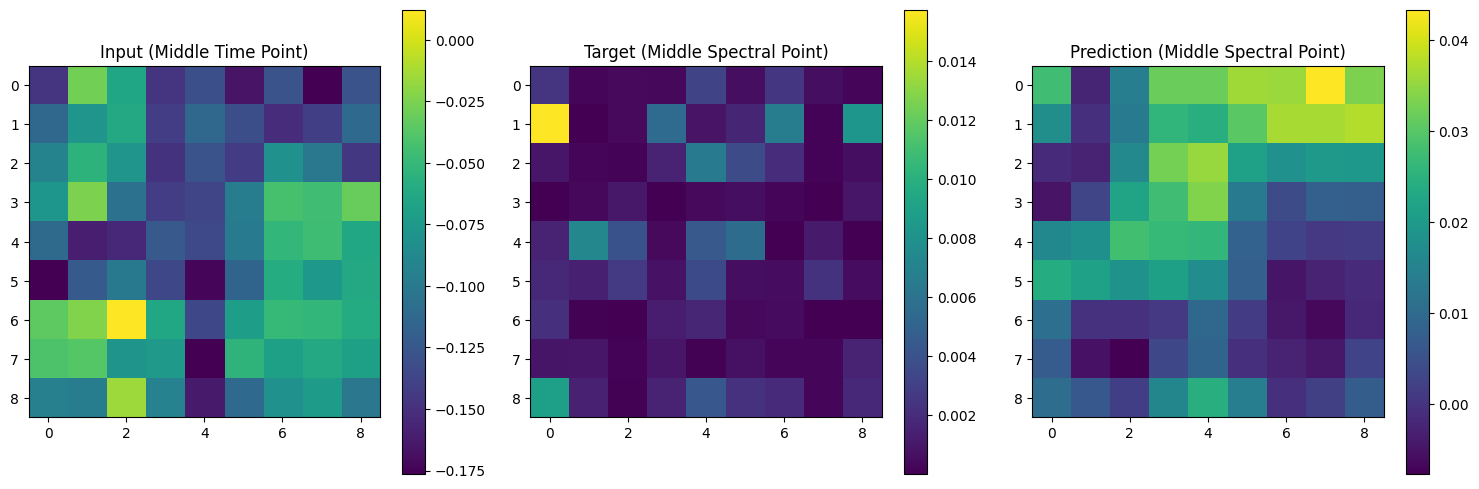

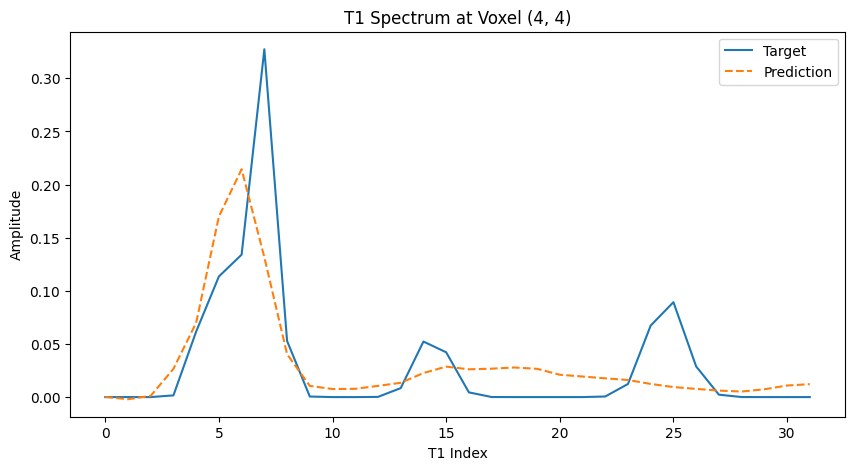

Example MSE: 0.001853
Example MAE: 0.021809


In [ ]:
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(inputs)

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

example_idx = 0

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(inputs[example_idx, 4, :, :])  # Middle temporal slice (4 out of 8)
plt.title('Input (Middle Time Point)')
plt.colorbar()

plt.subplot(132)
plt.imshow(targets[example_idx, 16, :, :])  # Middle spectral point (16 out of 32)
plt.title('Target (Middle Spectral Point)')
plt.colorbar()

plt.subplot(133)
plt.imshow(outputs[example_idx, 16, :, :])  # Middle spectral point
plt.title('Prediction (Middle Spectral Point)')
plt.colorbar()

plt.tight_layout()
plt.show()

voxel_x, voxel_y = 4, 4  # Middle voxel
plt.figure(figsize=(10, 5))
plt.plot(targets[example_idx, :, voxel_x, voxel_y], label='Target')
plt.plot(outputs[example_idx, :, voxel_x, voxel_y], '--', label='Prediction')
plt.title(f'T1 Spectrum at Voxel ({voxel_x}, {voxel_y})')
plt.xlabel('T1 Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

mse = np.mean((targets[example_idx] - outputs[example_idx])**2)
mae = np.mean(np.abs(targets[example_idx] - outputs[example_idx]))
print(f"Example MSE: {mse:.6f}")
print(f"Example MAE: {mae:.6f}")

In [21]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
final_mae,▁
final_mse,▁
final_psnr,▁
final_r2_score,▁
inference_time_ms,▁
learning_rate,███████████████▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁
memory_usage_mb,▁
model_parameters,▁
peak_detection_accuracy,▁
train_loss,█▇▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
